# Rydberg circuits

In addition to the fermionic setting introduced in [the first tutorial](./01_introduction_and_fermionic_circuits.ipynb), the Qiskit cold atom module naturally supports Rydberg hardware, which is the neutral atom implementation of qubits. They are described through the Hamiltonian:

$$
\hat{H}_{ryd} = \Omega \sum_i \sigma_{x,i} + \Delta \sum_i \sigma_{z,i} + V \sum_{i\neq j} \frac{\hat{n}_i \hat{n}_j}{|i-j|^6}
$$

The occupation number is defined as $\hat{n}_i = Z_i + \frac{1}{2}$ and the spin operators are $\sigma_{x,i} = \frac{1}{2}X_i$ as well as $\sigma_{z,i} = \frac{1}{2}Z_i$. Here, the unit of information, i.e. the individual wires in the quantum circuit, are given as quantum angular momenta or spins of length $S = 1/2$. The following simulation is based on the `SpinSimulator()` backend which was introduced for the case of high-dimensional spins in [the this tutorial](./04_collective_spin_hardware.ipynb).

In this tutorial we will focus on the production of two central experiments of Rydberg atoms:

Typical applications are:

- [Messin et al.](https://www.nature.com/articles/nphys1183), which demonstrate dynamically a Rydberg blockade.
- [Bernien et al.](https://arxiv.org/abs/1707.04344), which demonstrates larger spin structures that arise dynamically.




## Rydberg blockade in a two atom system

In the first step, we will employ a `qiskit-cold-atoms` to implement the foundational experiments on Rydberg blockade. By [Messin et al.](https://www.nature.com/articles/nphys1183). In a first step, we will simulate the simple Rabi oscillation experiments that they used as reference.

In [1]:
from qiskit import QuantumRegister
from qiskit.circuit import QuantumCircuit, Parameter

from qiskit_cold_atom.spins.spins_gate_library import RydbergFull
from qiskit_cold_atom.spins import SpinSimulator

import numpy as np
import matplotlib.pyplot as plt

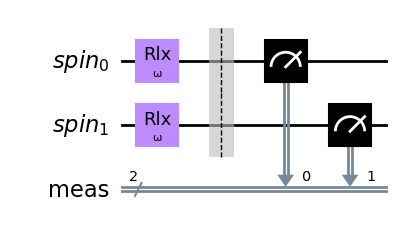

In [2]:
Nwires = 2
backend = SpinSimulator()
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx( omega_t, [0, 1])

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [3]:
phases = np.linspace(0, 2*np.pi,15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_rabi = backend.run(rabi_list, shots=500)
result_rabi = job_rabi.result()
counts_rabi = job_rabi.result().get_counts()

next we have to count the same of the two spins that are `1` at the same time

In [4]:
outcomes_rabi = [result_rabi.get_memory(i) for i in range(len(rabi_list))]
for i, outcome in enumerate(outcomes_rabi):
    for j, run in enumerate(outcome):
        outcomes_rabi[i][j] = np.array(run.split(' '), dtype = int)
outcomes_rabi = np.array(outcomes_rabi)

In [5]:
means_rabi = outcomes_rabi.mean(axis=1)
sum_rabi = means_rabi.sum(axis=1)

Text(0, 0.5, 'sum of spins up')

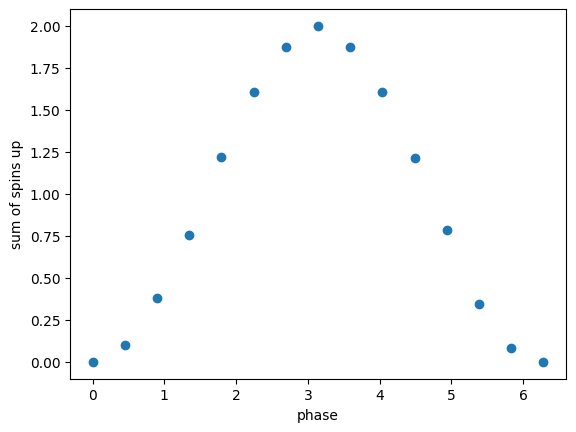

In [6]:
f, ax = plt.subplots()

ax.plot(phases, sum_rabi, 'o')
ax.set_xlabel('phase')
ax.set_ylabel('sum of spins up')

# Still a bug

The more `qiskit` fashion to write this circuit would be to write

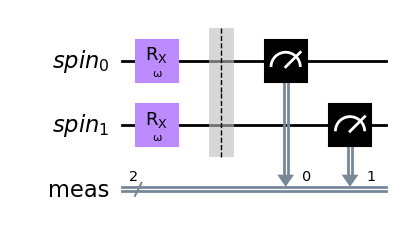

In [21]:
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rx( omega_t, [0, 1])

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

execute the circuit

In [23]:
phases = np.linspace(0, 2*np.pi,15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_rabi = backend.run(rabi_list, shots=500)
result_rabi = job_rabi.result()
#counts_rabi = job_rabi.result().get_counts()

QiskitColdAtomError: 'Gate rx has no defined generator'

### Including the Blockade

Next, we implement the protocol, which shows Rydberg blockade. This is done with the `rydberg_full` gate. It implements the already mentionned Hamiltonian time dynamics.

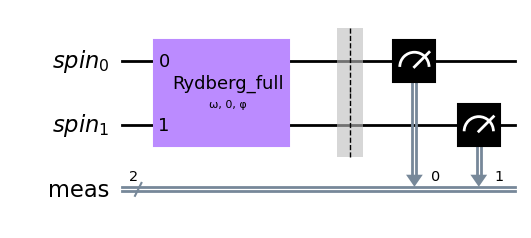

In [7]:
Nwires = 2
backend = SpinSimulator()
qc_block = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")
phi_t = Parameter("φ")

qc_block.rydberg_full(omega = omega_t, delta =0, phi = phi_t, modes=all_modes)

qc_block.measure_all()
qc_block.draw(output='mpl')

In [12]:
phases = np.linspace(0, 2*np.pi,15)

block_list = [
    qc_block.assign_parameters(
        {omega_t: phase, phi_t: phase*10},
        inplace=False,
    )
    for phase in phases
]

job_block = backend.run(block_list, shots=500)
result_block = job_block.result()

In [14]:
outcomes = [result_block.get_memory(i) for i in range(len(block_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

means_block = outcomes.mean(axis=1)
sum_block = means_block.sum(axis=1)

now we can compare the dynamics without Rydberg blockade and with Rydberg blockade

Text(0, 0.5, 'sum of spins up')

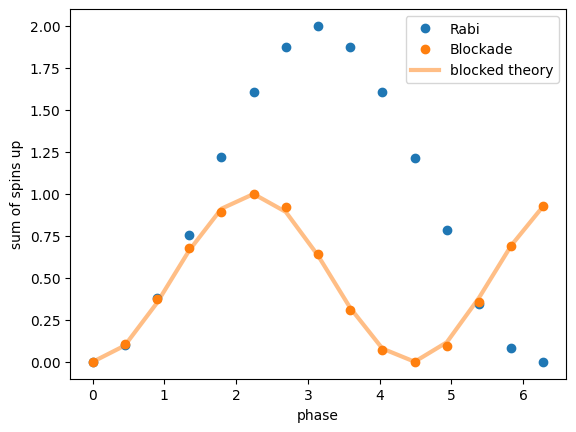

In [20]:
f, ax = plt.subplots()

ax.plot(phases, sum_rabi, 'o', label= 'Rabi')
ax.plot(phases, sum_block, 'o', label= 'Blockade')
ax.plot(phases, (1-np.cos(np.sqrt(2)*phases))/2, '-', color = "C1", alpha = 0.5, linewidth = 3, label= 'blocked theory')
ax.legend()
ax.set_xlabel('phase')
ax.set_ylabel('sum of spins up')

We can see observe two things:

- The blockade almost completely suppressed the existence of both spins being up at the same time. This is due to its energetic cost.
- The oscillation frequency is increased by a factor of $\sqrt(2)$. This is an indication of the coherent, entangled dynamics, which are discussed in detail in the original paper.

## Spin structures from Rydberg interactions

In this section we will reproduce some parts of the results of the paper by [Bernien et al.](https://arxiv.org/abs/1707.04344), which demonstrates larger spin structures that arise dynamically. We will do this first based on the local spin simulator and then demonstrate how it works in a remote system.

Let us start out once more with the reference without Rydberg blockade

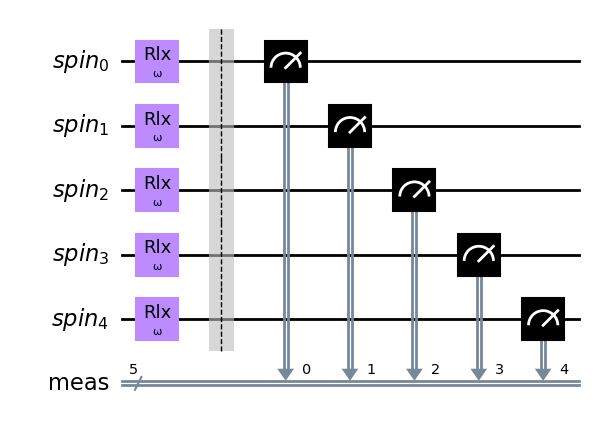

In [36]:
Nwires = 5
backend = SpinSimulator()
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx( omega_t, all_modes)

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [37]:
phases = np.linspace(0, 2*np.pi,15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_rabi = backend.run(rabi_list, shots=500)
result_rabi = job_rabi.result()

outcomes_rabi = [result_rabi.get_memory(i) for i in range(len(rabi_list))]
for i, outcome in enumerate(outcomes_rabi):
    for j, run in enumerate(outcome):
        outcomes_rabi[i][j] = np.array(run.split(' '), dtype = int)
outcomes_rabi = np.array(outcomes_rabi)

Text(0.5, 0, 'time')

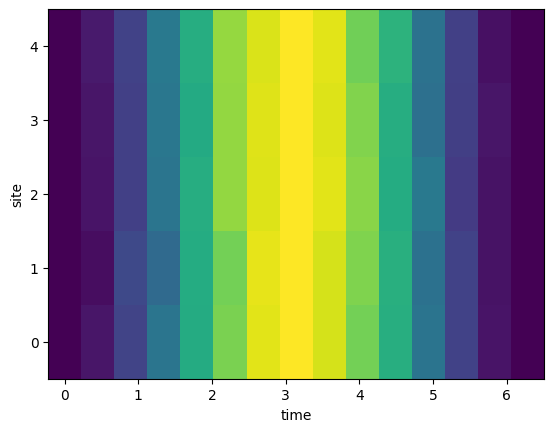

In [38]:
means_rabi = outcomes_rabi.mean(axis=1)

f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(Nwires), means_rabi.T)
ax.set_ylabel('site')
ax.set_xlabel('time')

We can see the all sites oscillate accordingly. So let us now implement the Blockade and observe its effect on the arising spin structures

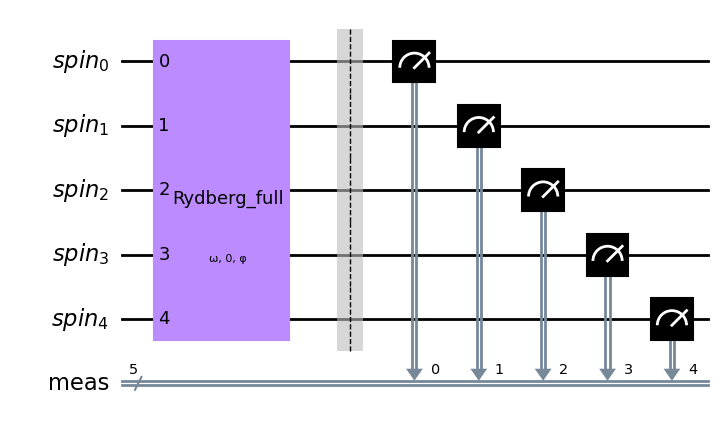

In [39]:
Nwires = 5
backend = SpinSimulator()
qc_block = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")
phi_t = Parameter("φ")

qc_block.rydberg_full(omega = omega_t, delta =0, phi = phi_t, modes=all_modes)

qc_block.measure_all()
qc_block.draw(output='mpl')

In [40]:
phases = np.linspace(0, 2*np.pi,15)

block_list = [
    qc_block.assign_parameters(
        {omega_t: phase, phi_t: phase*2},
        inplace=False,
    )
    for phase in phases
]

job_block = backend.run(block_list, shots=500)
result_block = job_block.result()

In [41]:
outcomes = [result_block.get_memory(i) for i in range(len(block_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

means_block = outcomes.mean(axis=1)

Text(0.5, 0, 'time')

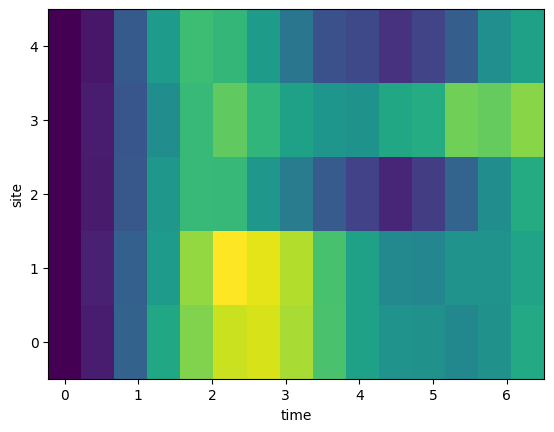

In [42]:
f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(Nwires), means_block.T)
ax.set_ylabel('site')
ax.set_xlabel('time')

**Bug** Clearly something is not going right here. Completely unclear too me what it is.

# Remote systems

Let us attempt to run the simulation on a remote backend

In [45]:
from qiskit_cold_atom.providers import ColdAtomProvider
from pprint import pprint

In [3]:
#provider = ColdAtomProvider.save_account(
#    url=[
#        "https://qlued.alqor.io/api/v2/singlequdit",
#        "https://qlued.alqor.io/api/v2/multiqudit",
#        "https://qlued.alqor.io/api/v2/fermions",
#        "https://qlued.alqor.io/api/v2/rydberg",
#    ],
#    username="name",
#    token="token",
#    overwrite=True
#)

In [46]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("alqor_rydberg_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rx', 'rz', 'rydberg_block', 'rydberg_full', 'barrier', 'measure']


first the reference

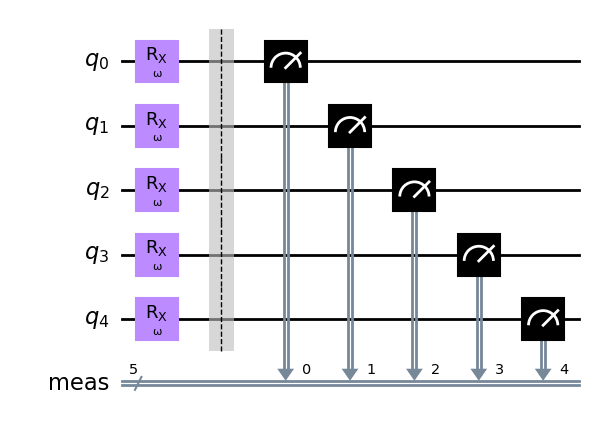

In [43]:
Nwires = 5

qc_rabi = QuantumCircuit(Nwires)

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rx( omega_t, all_modes)

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [47]:
job_remote_rabi = spin_device_backend.run(qc_rabi, shots=500)

QiskitColdAtomError: 'Cannot run circuit with unbound parameters.'

In [7]:
job_remote_rabi.job_id()

'20230414_132732-rydberg-fretchen-b4774'

now a the blockade

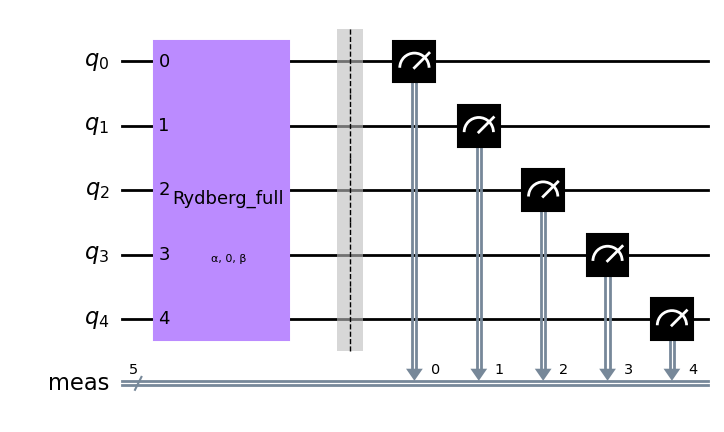

In [9]:
Nwires = 5
qc2 = QuantumCircuit(5)

all_modes=range(Nwires)
alpha = Parameter("α")
beta = Parameter("β")

qc2.rydberg_full(omega = alpha, delta =0, phi = beta, modes=all_modes)

qc2.measure_all()
qc2.draw(output='mpl')

In [13]:
phases = np.linspace(0, 2*np.pi,15)

circuit2_list = [
    qc2.assign_parameters(
        {alpha: phase, beta: phase*2},
        inplace=False,
    )
    for phase in phases
]

In [14]:
job2 = spin_device_backend.run(circuit2_list, shots=500)

In [15]:
job2.job_id()

'20230414_132821-rydberg-fretchen-222d6'

In [16]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id=job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


In [17]:
result2 = job_retrieved2.result()

make this a card of averages

In [18]:
outcomes = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

In [19]:
means_1 = outcomes.mean(axis=1)
means_1.shape

(15, 5)

Text(0.5, 0, 'time')

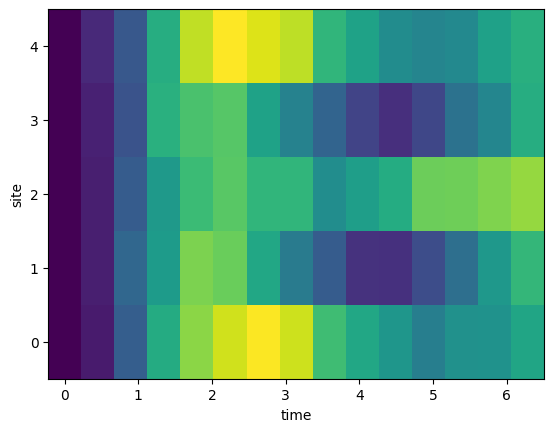

In [21]:
f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(5), means_1.T)
ax.set_ylabel('site')
ax.set_xlabel('time')